In [51]:
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from itertools import product
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim

## Load the dataset

In [34]:
adult = fetch_ucirepo(id=2)
X_original = adult.data.features
y_original = adult.data.targets
print(X_original)
print(y_original)

       age         workclass  fnlwgt  education  education-num  \
0       39         State-gov   77516  Bachelors             13   
1       50  Self-emp-not-inc   83311  Bachelors             13   
2       38           Private  215646    HS-grad              9   
3       53           Private  234721       11th              7   
4       28           Private  338409  Bachelors             13   
...    ...               ...     ...        ...            ...   
48837   39           Private  215419  Bachelors             13   
48838   64               NaN  321403    HS-grad              9   
48839   38           Private  374983  Bachelors             13   
48840   44           Private   83891  Bachelors             13   
48841   35      Self-emp-inc  182148  Bachelors             13   

           marital-status         occupation    relationship  \
0           Never-married       Adm-clerical   Not-in-family   
1      Married-civ-spouse    Exec-managerial         Husband   
2              

Extract x and y

In [35]:
X_age = np.array(X_original)[:,0]
X_wh = np.array(X_original)[:,12]
X_eduNum = np.array(X_original)[:,4]
X_sex = np.array(X_original)[:,9]
X_ms = np.array(X_original)[:,5]
y = np.array(y_original)[:]
y_cleaned = np.array([label[0].replace('.', '') for label in y])
encoder = LabelEncoder()
y = encoder.fit_transform(y_cleaned)
print(y)
print(np.unique(y))

[0 0 0 ... 0 0 1]
[0 1]


In [36]:
sex_encoder = LabelEncoder()
X_sex = sex_encoder.fit_transform(X_sex)
print(X_sex)
print(np.unique(X_sex))

[1 1 1 ... 1 1 1]
[0 1]


In [37]:
ms = LabelEncoder()
X_ms = ms.fit_transform(X_ms)
print(X_ms)
print(np.unique(X_ms))

[4 2 0 ... 2 0 2]
[0 1 2 3 4 5 6]


In [38]:
X = np.column_stack((X_age, X_eduNum, X_wh, X_sex, X_ms))
print(X.shape)

(48842, 5)


In [39]:
X = pd.DataFrame(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled)

[[ 0.02599598  1.136512   -0.03408696  0.70422049  0.91613819]
 [ 0.82830842  1.136512   -2.21303208  0.70422049 -0.41039699]
 [-0.04694151 -0.41933527 -0.03408696  0.70422049 -1.73693217]
 ...
 [-0.04694151  1.136512    0.77292975  0.70422049 -0.41039699]
 [ 0.39068346  1.136512   -0.03408696  0.70422049 -1.73693217]
 [-0.26575399  1.136512    1.57994645  0.70422049 -0.41039699]]


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=1234)

### Part 1: Logistic Regression

In [41]:
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [1000, 2000],
    'eta0': [0.01, 0.1, 0.001],
    'learning_rate': ['constant', 'adaptive'],
}

grid_search = GridSearchCV(SGDClassifier(loss='log_loss', random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("best param:", grid_search.best_params_)

model2 = SGDClassifier(
    loss='log_loss',
    learning_rate=grid_search.best_params_['learning_rate'],
    eta0=grid_search.best_params_['eta0'],
    max_iter=grid_search.best_params_['max_iter'],
    tol=0.1,
    random_state=42,
    alpha=grid_search.best_params_['alpha']
)
model2.fit(X_test, y_test)
y_pred = model2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

best param: {'alpha': 0.0001, 'eta0': 0.001, 'learning_rate': 'constant', 'max_iter': 1000}
Accuracy: 0.8029754998976318


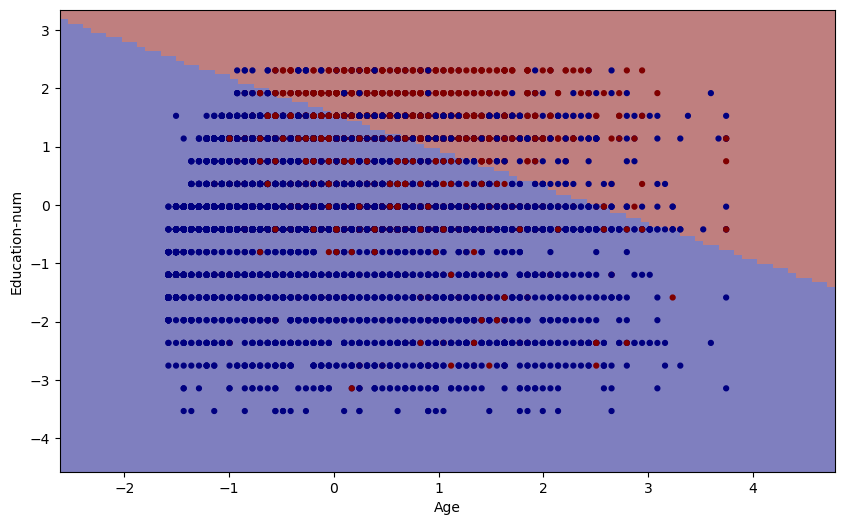

In [44]:
plot_kwargs = {'cmap': 'jet',
               'response_method': 'predict',
               'plot_method': 'pcolormesh',
               'shading': 'auto',
               'alpha': 0.5,
               'grid_resolution': 100}


X_train_2d = X_train[:, :2]
X_test_2d = X_test[:, :2]

model2.fit(X_train_2d, y_train)

figure, axes = plt.subplots(1, 1, figsize=(10, 6))
DecisionBoundaryDisplay.from_estimator(model2, X_train_2d, ax=axes, **plot_kwargs)
axes.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_test, edgecolor=None, s=12, cmap='jet')
plt.xlabel('Age')
plt.ylabel('Education-num')
plt.show()

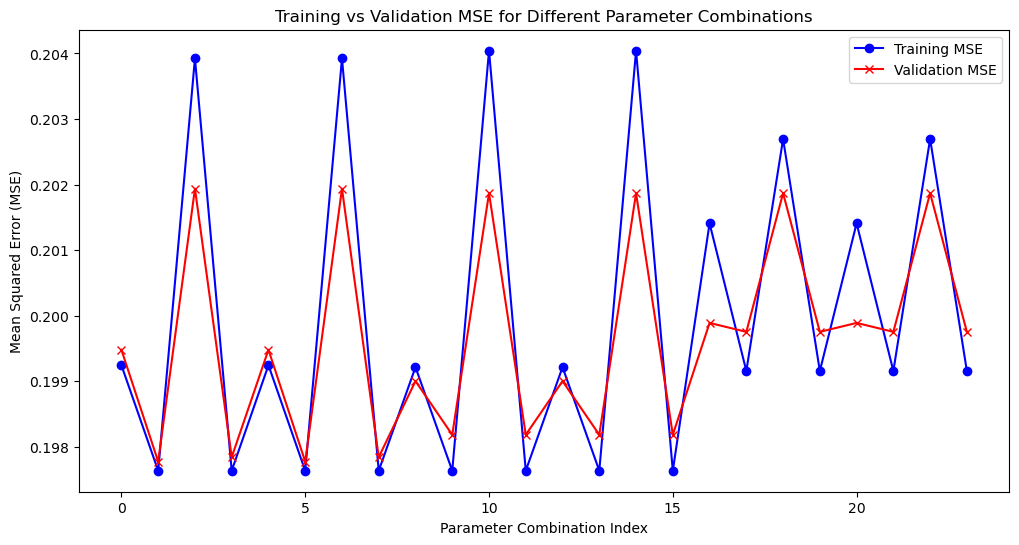

In [45]:
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [1000, 2000],
    'eta0': [0.01, 0.1],
    'learning_rate': ['constant', 'adaptive'],
}

param_combinations = list(product(
    param_grid['alpha'],
    param_grid['max_iter'],
    param_grid['eta0'],
    param_grid['learning_rate']
))
results = []

for params in param_combinations:
    alpha, max_iter, eta0, learning_rate = params

    model = SGDClassifier(
        loss='log_loss',
        alpha=alpha,
        max_iter=max_iter,
        eta0=eta0,
        learning_rate=learning_rate,
        random_state=42,
        tol=0.1
    )

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_test, y_val_pred)

    results.append({
        'alpha': alpha,
        'max_iter': max_iter,
        'eta0': eta0,
        'learning_rate': learning_rate,
        'train_mse': train_mse,
        'val_mse': val_mse
    })

results_df = pd.DataFrame(results)

plt.figure(figsize=(12, 6))

plt.plot(range(len(results_df)), results_df['train_mse'], color='blue', label='Training MSE', marker='o')
plt.plot(range(len(results_df)), results_df['val_mse'], color='red', label='Validation MSE', marker='x')

plt.legend()
plt.xlabel("Parameter Combination Index")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Training vs Validation MSE for Different Parameter Combinations")
plt.show()

Mean: 0.8006, Std: 0.0051, Params: {'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'constant', 'max_iter': 1000}
Mean: 0.8006, Std: 0.0051, Params: {'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'constant', 'max_iter': 2000}
Mean: 0.8026, Std: 0.0034, Params: {'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'adaptive', 'max_iter': 1000}
Mean: 0.8026, Std: 0.0034, Params: {'alpha': 0.0001, 'eta0': 0.01, 'learning_rate': 'adaptive', 'max_iter': 2000}
Mean: 0.7927, Std: 0.0103, Params: {'alpha': 0.0001, 'eta0': 0.1, 'learning_rate': 'constant', 'max_iter': 1000}
Mean: 0.7927, Std: 0.0103, Params: {'alpha': 0.0001, 'eta0': 0.1, 'learning_rate': 'constant', 'max_iter': 2000}
Mean: 0.8025, Std: 0.0034, Params: {'alpha': 0.0001, 'eta0': 0.1, 'learning_rate': 'adaptive', 'max_iter': 1000}
Mean: 0.8025, Std: 0.0034, Params: {'alpha': 0.0001, 'eta0': 0.1, 'learning_rate': 'adaptive', 'max_iter': 2000}
Mean: 0.8030, Std: 0.0029, Params: {'alpha': 0.0001, 'eta0': 0.001, 'learning_rate': 'consta

C:\Users\alanj\AppData\Local\Temp\ipykernel_23904\1822420130.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


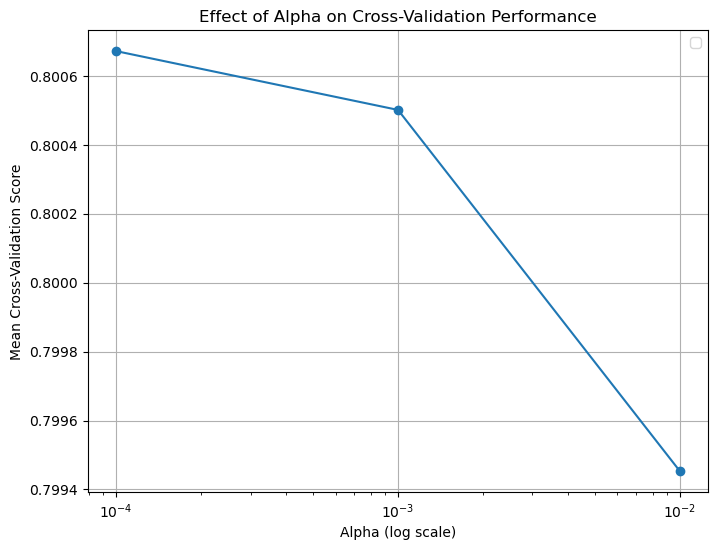

In [53]:
cv_results = grid_search.cv_results_

mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']
params = cv_results['params']

for mean, std, param in zip(mean_test_scores, std_test_scores, params):
    print(f"Mean: {mean:.4f}, Std: {std:.4f}, Params: {param}")
alphas = param_grid['alpha']
alpha_scores = [
    np.mean([mean_test_scores[i] for i in range(len(params)) if params[i]['alpha'] == alpha])
    for alpha in alphas
]

plt.figure(figsize=(8, 6))
plt.plot(alphas, alpha_scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Cross-Validation Score')
plt.title('Effect of Alpha on Cross-Validation Performance')
plt.legend()
plt.grid(True)
plt.show()

## Part 2: neural network

In [49]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # 转为列向量
X_val_tensor = torch.tensor(X_test, dtype=torch.float32)
y_val_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

lr = 0.001
hidden_size = 32
epochs = 100
batch_size = 32 

model = NeuralNet(input_size=X_train_tensor.shape[1], hidden_size=hidden_size, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor).numpy()
    y_val_pred = model(X_val_tensor).numpy()

    y_train_pred_class = (y_train_pred >= 0.5).astype(int)
    y_val_pred_class = (y_val_pred >= 0.5).astype(int)

    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_test, y_val_pred)
    
    train_acc = accuracy_score(y_train, y_train_pred_class)
    val_acc = accuracy_score(y_test, y_val_pred_class)

print(f"Training MSE: {train_mse:.4f}")
print(f"Validation MSE: {val_mse:.4f}")
print(f"Train accuracy score: {train_acc:.4f}")
print(f"Test accuracy score: {val_acc:.4f}")

Training MSE: 0.1131
Validation MSE: 0.1153
Train accuracy score: 0.8338
Test accuracy score: 0.8286


Batch Size: 8, Training MSE: 0.1140, Validation MSE: 0.1161
Batch Size: 16, Training MSE: 0.1136, Validation MSE: 0.1159
Batch Size: 32, Training MSE: 0.1134, Validation MSE: 0.1157
Batch Size: 64, Training MSE: 0.1131, Validation MSE: 0.1153
Batch Size: 128, Training MSE: 0.1131, Validation MSE: 0.1153


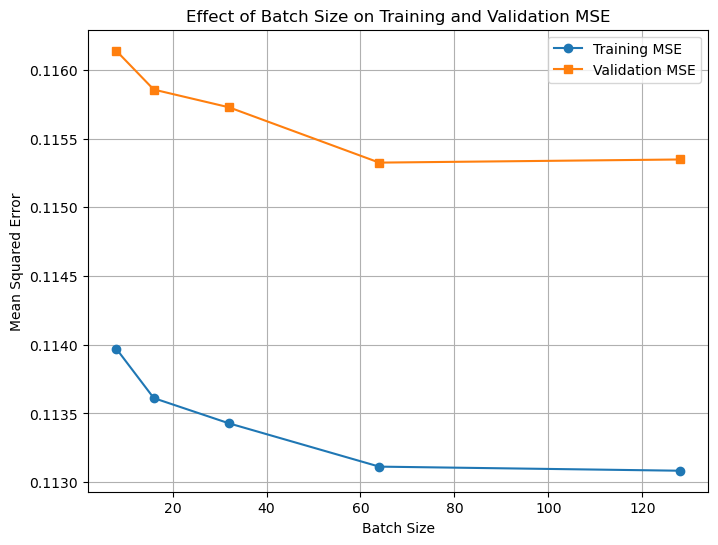

In [47]:
training_mse = []
val_mse_list = []

batch_sizes_2 = [8, 16, 32, 64, 128]

for batch_size in batch_sizes_2:
    model = NeuralNet(input_size=X_train_tensor.shape[1], hidden_size=hidden_size, output_size=1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        y_train_pred = model(X_train_tensor).numpy()
        y_val_pred = model(X_val_tensor).numpy()

        train_mse = mean_squared_error(y_train, y_train_pred)
        val_mse = mean_squared_error(y_test, y_val_pred)

    training_mse.append(train_mse)
    val_mse_list.append(val_mse)

    print(f"Batch Size: {batch_size}, Training MSE: {train_mse:.4f}, Validation MSE: {val_mse:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(batch_sizes_2, training_mse, marker='o', label='Training MSE')
plt.plot(batch_sizes_2, val_mse_list, marker='s', label='Validation MSE')
plt.xlabel('Batch Size')
plt.ylabel('Mean Squared Error')
plt.title('Effect of Batch Size on Training and Validation MSE')
plt.legend()
plt.grid(True)
plt.show()